# 📦 Descarga de variables climáticas desde Copernicus Climate Data Store (CDS)

Este notebook automatiza la descarga de variables climáticas desde la **API del Climate Data Store (CDS)** de **Copernicus**, utilizando el conjunto de productos:

> **Agro-meteorological indicators from 1979 to present derived from reanalysis**  
> [`sis-agrometeorological-indicators`](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-agrometeorological-indicators?tab=overview)

Este conjunto de datos ofrece variables esenciales para análisis climáticos, derivadas del reanálisis ERA5.

---

### 📈 Variables consideradas

Las variables climáticas disponibles incluyen:

- ☀️ **`solar_radiation_flux`** — Radiación solar (W/m²)
- 💧 **`2m_relative_humidity`** — Humedad relativa a 2 metros (%)
- 🌡 **`2m_temperature`** — Temperatura a 2 metros (máxima, mínima y media, °C)
- 💨 **`10m_wind_speed`** — Velocidad del viento a 10 metros (m/s)
- ❄️ **`2m_dewpoint_temperature`** — Temperatura del punto de rocío (°C)

Estas variables se descargan en formato `.nc.tgz`, posteriormente se descomprimen y pueden ser utilizadas directamente para análisis, modelamiento o visualización.

---

### 🗂 Organización de carpetas

Los datos se organizan de manera estructurada por **etapa de procesamiento** y **tipo de variable**. Por ejemplo, para `solar_radiation_flux`:

- **`raw/`**: Contiene los archivos `.nc.tgz` tal como se descargan desde la API(Una carpeta por mes).
- **`interim/`**: 
- **`processed/`**: Archivos `.nc` descomprimidos y recortados en el área de interés (un archivo .nc por día).

Este esquema permite escalar fácilmente a múltiples variables y fuentes manteniendo trazabilidad y reproducibilidad.

---



# 🧠 Carga de funciones del proyecto

En esta sección se importan todas las funciones necesarias que han sido previamente desarrolladas en los scripts del proyecto:

- ☀️ `download.copernicus`  
  Funciones para descargar datos climáticos desde Copernicus (temperatura, radiación, humedad, etc.).

- 🔧 `download.utils`  
  Funciones utilitarias como:
  - Verificación de conexión a Internet
  - Validación de archivos descargados
  - Registro de logs

- 🛠 `download.process`  
  Funciones de procesamiento espacial de los datos, incluyendo:
  - `descomprimir_archivo_gz()` → descomprime archivos `.gz` en formatos `.tif` o `.nc`
  - `recortar_raster()` → recorta un raster con shapefile o bounding box

Estas funciones encapsulan toda la lógica del pipeline para mantener el notebook limpio, modular y reutilizable.

In [1]:
# Importación paquetes
import subprocess
import sys
from pathlib import Path
import geopandas as gpd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import box
from datetime import date, timedelta
import zipfile

# Ruta base: carpeta raíz del proyecto (2 niveles arriba del notebook)
ruta_base = Path.cwd().parent.resolve()
sys.path.append(str(ruta_base))

# Confirmar que el path es correcto
print(f"Ruta base del proyecto agregada a sys.path: {ruta_base}")

# Importación de funciones de descarga y procesamiento
from download.process import descomprimir_archivo_gz, recortar_raster, extract_zip_flat
from download.copernicus import download_variable, download_simple_variable, download_humidity, ensure_cdsapi_config
from download.utils import log_event

Ruta base del proyecto agregada a sys.path: D:\OneDrive - CGIAR\Desktop\climate_data_downloader


## 📍 Área de interés y configuración global de fechas

En esta sección se define la configuración **base** que será utilizada por todas las funciones de descarga a lo largo del notebook:

- **Área de interés (AOI)**:  
  Se carga el shapefile del departamento **Valle del Cauca**, ubicado en `data/auxiliary/shapefiles/valle/valle.shp`.  
  A partir de este archivo se calcula automáticamente el **bounding box** necesario para las consultas a la API de Copernicus(si se requiere cambiar el área de interés se debería dejar el shapefile en la carpeta `data/auxiliry` o se podrian definir los bounding box manualmente)

- **Rango de fechas**:  
  Se establece un rango temporal definido por `fecha_inicio` y `fecha_fin`, con un intervalo diario.  
  Este rango será reutilizado para construir las fechas de descarga  para las variables de **Copernicus**. (A pesar de que el rango es diario el proceso de descarga funciona por mes, cada descarga trae una carpeta comprimida con los archivos diarios correspondientes al mes)

Estas variables globales permiten mantener un flujo de trabajo coherente y evitar duplicación de parámetros en cada sección del notebook.

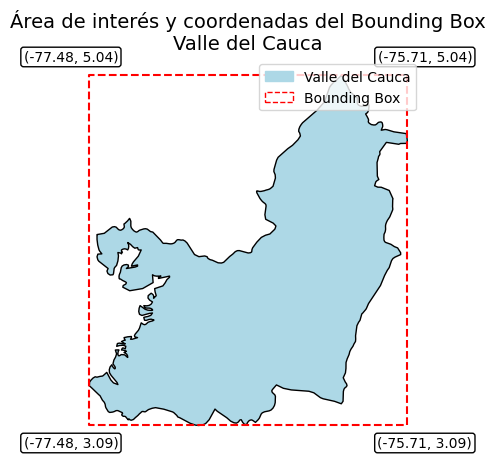

📅 Fecha de inicio de descarga: 2014-01-01
📅 Fecha de fin de descarga:    2014-01-10
🧭 Bounding Box: [N: 5.04, W: -77.48, S: 3.09, E: -75.71]


In [2]:

# 📍 Área de interés
shapefile_valle = ruta_base / "data" / "auxiliary" / "shapefiles" / "valle" / "valle.shp"
gdf_valle = gpd.read_file(shapefile_valle)

# Bounding box
gdf_valle_bounds = gdf_valle.total_bounds  # [xmin, ymin, xmax, ymax]
gdf_valle_bbox = [gdf_valle_bounds[3], gdf_valle_bounds[0], gdf_valle_bounds[1], gdf_valle_bounds[2]]  # [N, W, S, E]

xmin, ymin, xmax, ymax = gdf_valle_bounds
bbox_polygon = box(xmin, ymin, xmax, ymax)
gdf_bbox = gpd.GeoDataFrame(geometry=[bbox_polygon], crs=gdf_valle.crs)

# 🎨 Plot
fig, ax = plt.subplots(figsize=(5, 5))
gdf_valle.plot(ax=ax, color='lightblue', edgecolor='black')
gdf_bbox.boundary.plot(ax=ax, color='red', linestyle='--')

# Coordenadas en las esquinas (lon, lat)
offset = 0.1  # Separación para que las etiquetas no se solapen
corner_coords = {
    "SW": (xmin - offset, ymin - offset, xmin, ymin),
    "NW": (xmin - offset, ymax + offset, xmin, ymax),
    "SE": (xmax + offset, ymin - offset, xmax, ymin),
    "NE": (xmax + offset, ymax + offset, xmax, ymax),
}

for label, (x, y, lon, lat) in corner_coords.items():
    ax.text(x, y, f"({lon:.2f}, {lat:.2f})", fontsize=10, ha='center', va='center',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))

# Leyenda
valle_patch = mpatches.Patch(color='lightblue', label='Valle del Cauca')
bbox_line = mpatches.Patch(edgecolor='red', facecolor='none', linestyle='--', label='Bounding Box')
ax.legend(handles=[valle_patch, bbox_line])

ax.set_title("Área de interés y coordenadas del Bounding Box\nValle del Cauca", fontsize=14)
ax.set_axis_off()
plt.show()

# 📆 Fechas
fecha_inicio = date(2014, 1, 1)
fecha_fin = date(2014, 1, 10)

print(f"📅 Fecha de inicio de descarga: {fecha_inicio.strftime('%Y-%m-%d')}")
print(f"📅 Fecha de fin de descarga:    {fecha_fin.strftime('%Y-%m-%d')}")
print(f"🧭 Bounding Box: [N: {gdf_valle_bbox[0]:.2f}, W: {gdf_valle_bbox[1]:.2f}, S: {gdf_valle_bbox[2]:.2f}, E: {gdf_valle_bbox[3]:.2f}]")


### 🔐 Configuración de la API de Copernicus

Para acceder a los datos, es necesario autenticar la sesión usando una clave API personal. Este proceso se gestiona automáticamente:

- El notebook genera el archivo `.cdsapirc` a partir de las credenciales definidas en el archivo `.env`.
- Si el archivo ya existe, se actualiza con la nueva clave.
- El archivo `.cdsapirc` se crea en el directorio home del usuario (`~/.cdsapirc`), como lo requiere la librería `cdsapi`.

> 📌 Asegúrate de haber registrado tu cuenta en el Climate Data Store y de haber copiado tu API key en el archivo `.env`.

---

Una vez configurado todo, este notebook permitirá descargar datos climáticos históricos y actuales para el área de estudio deseada.

In [3]:
RAW_COPERNICUS = ruta_base / "data" / "raw" / "copernicus"
INTERIM_COPERNICUS = ruta_base / "data" / "interim" / "copernicus"
PROCESSED_COPERNICUS = ruta_base / "data" / "processed" / "copernicus"

# Variables climáticas de Copernicus
copernicus_variables = [
    "solar_radiation_flux",
    "2m_relative_humidity",
    "2m_temperature_maximum",
    "2m_temperature_minimum",
    "2m_temperature_mean",
    "2m_dewpoint_temperature",
    "10m_wind_speed"
]

# Diccionarios para almacenar rutas por variable
RAW_COPERNICUS_VARS = {}
INTERIM_COPERNICUS_VARS = {}
PROCESSED_COPERNICUS_VARS = {}

# Crear subcarpetas organizadas por variable dentro de cada etapa
for var in copernicus_variables:
    var_folder = var.upper()

    raw_var_path = RAW_COPERNICUS / var_folder
    interim_var_path = INTERIM_COPERNICUS / var_folder
    processed_var_path = PROCESSED_COPERNICUS / var_folder

    # Crear las carpetas si no existen
    for path in [raw_var_path, interim_var_path, processed_var_path]:
        path.mkdir(parents=True, exist_ok=True)

    # Guardar rutas en diccionarios para uso posterior
    RAW_COPERNICUS_VARS[var] = raw_var_path
    INTERIM_COPERNICUS_VARS[var] = interim_var_path
    PROCESSED_COPERNICUS_VARS[var] = processed_var_path

print("✅ Carpetas para cada variable de Copernicus creadas exitosamente.")

✅ Carpetas para cada variable de Copernicus creadas exitosamente.


In [4]:
# Asegurarse de que el archivo .cdsapirc exista o se genere
ensure_cdsapi_config()

✅ Archivo .cdsapirc creado o reemplazado en: C:\Users\dagudelo\.cdsapirc


## ☀️ Descarga de radiación solar (`solar_radiation_flux`)

In [5]:
# ⚙️ Parámetros base
producto = "sis-agrometeorological-indicators"
variable = "solar_radiation_flux"
raw_dir = RAW_COPERNICUS_VARS[variable]
processed_dir = PROCESSED_COPERNICUS_VARS[variable]

# 🔁 Construir conjunto (año, mes) desde el rango definido
fechas_unicas = set()
fecha = fecha_inicio
while fecha <= fecha_fin:
    fechas_unicas.add((fecha.year, fecha.month))
    fecha += timedelta(days=1)
    
# 📥 Descargar y 🗜️ descomprimir por mes
for (anio, mes) in sorted(fechas_unicas):
    nombre_archivo_zip = f"{variable}_{anio}_{mes:02d}.nc.zip"
    nombre_archivo_nc = nombre_archivo_zip.replace(".zip", "")
    ruta_zip = raw_dir / nombre_archivo_zip
    ruta_nc = processed_dir / nombre_archivo_nc

    print(f"\n📥 Descargando {variable} → {anio}-{mes:02d}")
    try:
        download_simple_variable(
            product=producto,
            variable=variable,
            year=anio,
            month=mes,
            area=gdf_valle_bbox,
            output_path=ruta_zip
        )

        print(f"🗜️ Descomprimiendo → {ruta_nc.name}")
        extract_zip_flat(ruta_zip, processed_dir)

    except Exception as e:
        print(f"❌ Error en {anio}-{mes:02d}: {e}")



📥 Descargando solar_radiation_flux → 2014-01


2025-04-23 10:42:31,804 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 10:42:31,806 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 10:42:32,380 INFO [2024-02-01T00:00:00] An issue has been identified with version 1.0 & version 1.1 of this dataset. Please see the Known issues table in the Documentation for more information.
2025-04-23 10:42:32,382 INFO Request ID is 9be5f36f-302e-4f42-adf5-3f037c6287e4
2025-04-23 10:42:32,659 INFO status has been updated to accepted
2025-04-23 10:42:47,124 INFO status has been updated to successful


d38f0c921b141f85e8336c3dc3affda1.zip:   0%|          | 0.00/912k [00:00<?, ?B/s]

🗜️ Descomprimiendo → solar_radiation_flux_2014_01.nc
✅ Extraído: Solar-Radiation-Flux_C3S-glob-agric_AgERA5_20140101_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.4776584039999.n
✅ Extraído: Solar-Radiation-Flux_C3S-glob-agric_AgERA5_20140102_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.4776584039999.n
✅ Extraído: Solar-Radiation-Flux_C3S-glob-agric_AgERA5_20140103_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.4776584039999.n
✅ Extraído: Solar-Radiation-Flux_C3S-glob-agric_AgERA5_20140104_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.4776584039999.n
✅ Extraído: Solar-Radiation-Flux_C3S-glob-agric_AgERA5_20140105_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.4776584039999.n
✅ Extraído: Solar-Radiation-Flux_C3S-glob-agric_AgERA5_20140106_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.092860

## 💧 Descarga de Humedad Relativa (`2m_relative_humidity`)


In [6]:
# ⚙️ Parámetros base
producto = "sis-agrometeorological-indicators"
variable = "2m_relative_humidity"
raw_dir = RAW_COPERNICUS_VARS[variable]
processed_dir = PROCESSED_COPERNICUS_VARS[variable]

# 🔁 Construir conjunto (año, mes) desde el rango definido
fechas_unicas = set()
fecha = fecha_inicio
while fecha <= fecha_fin:
    fechas_unicas.add((fecha.year, fecha.month))
    fecha += timedelta(days=1)

# 📥 Descargar y 🗜️ descomprimir por mes
for (anio, mes) in sorted(fechas_unicas):
    nombre_archivo_zip = f"{variable}_{anio}_{mes:02d}.nc.zip"
    nombre_archivo_nc = nombre_archivo_zip.replace(".zip", "")
    ruta_zip = raw_dir / nombre_archivo_zip
    ruta_nc = processed_dir / nombre_archivo_nc

    print(f"\n📥 Descargando humedad relativa → {anio}-{mes:02d}")
    try:
        download_humidity(
            product=producto,
            year=anio,
            month=mes,
            area=gdf_valle_bbox,
            output_path=ruta_zip
        )

        print(f"🗜️ Descomprimiendo → {ruta_nc.name}")
        extract_zip_flat(ruta_zip, processed_dir)

    except Exception as e:
        print(f"❌ Error en {anio}-{mes:02d}: {e}")




📥 Descargando humedad relativa → 2014-01
✅ Archivo .cdsapirc creado o reemplazado en: C:\Users\dagudelo\.cdsapirc


2025-04-23 10:43:13,501 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 10:43:13,502 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 10:43:14,927 INFO [2024-02-01T00:00:00] An issue has been identified with version 1.0 & version 1.1 of this dataset. Please see the Known issues table in the Documentation for more information.
2025-04-23 10:43:14,928 INFO Request ID is c5363e8e-9d79-46c9-b04d-abfb75464482
2025-04-23 10:43:15,140 INFO status has been updated to accepted
2025-04-23 10:43:29,417 INFO status has been updated to successful


7d2aa05ba2b3c83247b2cd38b9e520fe.zip:   0%|          | 0.00/914k [00:00<?, ?B/s]

🗜️ Descomprimiendo → 2m_relative_humidity_2014_01.nc
✅ Extraído: Relative-Humidity-2m-18h_C3S-glob-agric_AgERA5_20140101_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.47765840399
✅ Extraído: Relative-Humidity-2m-18h_C3S-glob-agric_AgERA5_20140102_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.47765840399
✅ Extraído: Relative-Humidity-2m-18h_C3S-glob-agric_AgERA5_20140103_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.47765840399
✅ Extraído: Relative-Humidity-2m-18h_C3S-glob-agric_AgERA5_20140104_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.47765840399
✅ Extraído: Relative-Humidity-2m-18h_C3S-glob-agric_AgERA5_20140105_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.47765840399
✅ Extraído: Relative-Humidity-2m-18h_C3S-glob-agric_AgERA5_20140106_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.09

##  🌡 Descarga de temperatura(max, min y mean) (`2m_temperature`)

In [7]:
# ⚙️ Parámetros base
producto = "sis-agrometeorological-indicators"
variable_base = "2m_temperature"

# 🗺️ Mapeo correcto: nombre de estadístico para el request CDS
statistic_mapping = {
    "min": "24_hour_minimum",
    "max": "24_hour_maximum",
    "mean": "24_hour_mean"
}

# Nombres completos para las rutas
estadisticas = {
    "min": "2m_temperature_minimum",
    "max": "2m_temperature_maximum",
    "mean": "2m_temperature_mean"
}

# 📂 Directorios por estadístico
raw_dirs = {key: RAW_COPERNICUS_VARS[estadisticas[key]] for key in estadisticas}
processed_dirs = {key: PROCESSED_COPERNICUS_VARS[estadisticas[key]] for key in estadisticas}

# 🔁 Rango de fechas: construir conjunto (año, mes)
fechas_unicas = set()
fecha = fecha_inicio
while fecha <= fecha_fin:
    fechas_unicas.add((fecha.year, fecha.month))
    fecha += timedelta(days=1)

# 📥 Descargar y 🗜️ Descomprimir
for (anio, mes) in sorted(fechas_unicas):
    print(f"\n📆 {anio}-{mes:02d} → Temperatura 2m (min/max/mean)")

    for stat_key, var_name in estadisticas.items():
        stat_api = statistic_mapping[stat_key]
        nombre_archivo_zip = f"{var_name}_{anio}_{mes:02d}.zip"
        nombre_archivo_nc = nombre_archivo_zip.replace(".zip", ".nc")

        ruta_zip = raw_dirs[stat_key] / nombre_archivo_zip
        ruta_nc = processed_dirs[stat_key] / nombre_archivo_nc

        try:
            print(f"📥 Descargando {stat_key} → {nombre_archivo_zip}")
            download_variable(
                product=producto,
                variable=variable_base,
                statistic=stat_api,  # ✅ Mapeado correctamente
                year=anio,
                month=mes,
                area=gdf_valle_bbox,
                output_path=ruta_zip
            )

            print(f"🗜️ Descomprimiendo → {ruta_nc.name}")
            extract_zip_flat(ruta_zip, processed_dirs[stat_key])
            
        except Exception as e:
            print(f"❌ Error en {var_name} {anio}-{mes:02d}: {e}")



📆 2014-01 → Temperatura 2m (min/max/mean)
📥 Descargando min → 2m_temperature_minimum_2014_01.zip


2025-04-23 10:44:28,284 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 10:44:28,285 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 10:44:28,905 INFO [2024-02-01T00:00:00] An issue has been identified with version 1.0 & version 1.1 of this dataset. Please see the Known issues table in the Documentation for more information.
2025-04-23 10:44:28,906 INFO Request ID is 8f847cf9-8090-401f-94ad-6f107766223b
2025-04-23 10:44:29,339 INFO status has been updated to accepted
2025-04-23 10:44:43,787 INFO status has been updated to successful


d3da1e745d6460ba43266e4ef32c7f53.zip:   0%|          | 0.00/913k [00:00<?, ?B/s]

🗜️ Descomprimiendo → 2m_temperature_minimum_2014_01.nc
✅ Extraído: Temperature-Air-2m-Min-24h_C3S-glob-agric_AgERA5_20140101_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.477658403
✅ Extraído: Temperature-Air-2m-Min-24h_C3S-glob-agric_AgERA5_20140102_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.477658403
✅ Extraído: Temperature-Air-2m-Min-24h_C3S-glob-agric_AgERA5_20140103_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.477658403
✅ Extraído: Temperature-Air-2m-Min-24h_C3S-glob-agric_AgERA5_20140104_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.477658403
✅ Extraído: Temperature-Air-2m-Min-24h_C3S-glob-agric_AgERA5_20140105_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.477658403
✅ Extraído: Temperature-Air-2m-Min-24h_C3S-glob-agric_AgERA5_20140106_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.

2025-04-23 10:44:47,574 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 10:44:47,576 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 10:44:48,421 INFO [2024-02-01T00:00:00] An issue has been identified with version 1.0 & version 1.1 of this dataset. Please see the Known issues table in the Documentation for more information.
2025-04-23 10:44:48,423 INFO Request ID is 9561ebf2-1260-4391-ac29-2c275690a315
2025-04-23 10:44:48,634 INFO status has been updated to accepted
2025-04-23 10:45:10,934 INFO status has been updated to successful


9970ef7e88a8b0de4e1e8d3e3b5ce3a1.zip:   0%|          | 0.00/913k [00:00<?, ?B/s]

🗜️ Descomprimiendo → 2m_temperature_maximum_2014_01.nc
✅ Extraído: Temperature-Air-2m-Max-24h_C3S-glob-agric_AgERA5_20140101_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.477658403
✅ Extraído: Temperature-Air-2m-Max-24h_C3S-glob-agric_AgERA5_20140102_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.477658403
✅ Extraído: Temperature-Air-2m-Max-24h_C3S-glob-agric_AgERA5_20140103_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.477658403
✅ Extraído: Temperature-Air-2m-Max-24h_C3S-glob-agric_AgERA5_20140104_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.477658403
✅ Extraído: Temperature-Air-2m-Max-24h_C3S-glob-agric_AgERA5_20140105_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.477658403
✅ Extraído: Temperature-Air-2m-Max-24h_C3S-glob-agric_AgERA5_20140106_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.

2025-04-23 10:45:14,842 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 10:45:14,843 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 10:45:15,764 INFO [2024-02-01T00:00:00] An issue has been identified with version 1.0 & version 1.1 of this dataset. Please see the Known issues table in the Documentation for more information.
2025-04-23 10:45:15,765 INFO Request ID is 21a655f1-d6d8-49bb-a3ef-6e6f90b9761b
2025-04-23 10:45:15,980 INFO status has been updated to accepted
2025-04-23 10:45:25,073 INFO status has been updated to running
2025-04-23 10:45:30,366 INFO status has been updated to successful


32922142a8c653f8fcbaf86e119bff1c.zip:   0%|          | 0.00/913k [00:00<?, ?B/s]

🗜️ Descomprimiendo → 2m_temperature_mean_2014_01.nc
✅ Extraído: Temperature-Air-2m-Mean-24h_C3S-glob-agric_AgERA5_20140101_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.47765840
✅ Extraído: Temperature-Air-2m-Mean-24h_C3S-glob-agric_AgERA5_20140102_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.47765840
✅ Extraído: Temperature-Air-2m-Mean-24h_C3S-glob-agric_AgERA5_20140103_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.47765840
✅ Extraído: Temperature-Air-2m-Mean-24h_C3S-glob-agric_AgERA5_20140104_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.47765840
✅ Extraído: Temperature-Air-2m-Mean-24h_C3S-glob-agric_AgERA5_20140105_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.47765840
✅ Extraído: Temperature-Air-2m-Mean-24h_C3S-glob-agric_AgERA5_20140106_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.

##  ❄️ Descarga de temperatura de rocío (`2m_dewpoint_temperature`)

In [8]:
# ⚙️ Parámetros base
producto = "sis-agrometeorological-indicators"
variable = "2m_dewpoint_temperature"
statistic = "24_hour_mean"

# 📂 Rutas (asegúrate de que existan las claves en estos diccionarios)
raw_dir = RAW_COPERNICUS_VARS[variable]
processed_dir = PROCESSED_COPERNICUS_VARS[variable]

# 🔁 Construir conjunto (año, mes) desde el rango definido
fechas_unicas = set()
fecha = fecha_inicio
while fecha <= fecha_fin:
    fechas_unicas.add((fecha.year, fecha.month))
    fecha += timedelta(days=1)

# 📥 Descargar y 🗜️ descomprimir por mes
for (anio, mes) in sorted(fechas_unicas):
    nombre_archivo_zip = f"{variable}_{anio}_{mes:02d}.zip"
    nombre_archivo_nc = nombre_archivo_zip.replace(".zip", ".nc")

    ruta_zip = raw_dir / nombre_archivo_zip
    ruta_nc = processed_dir / nombre_archivo_nc

    print(f"\n📥 Descargando {variable} → {anio}-{mes:02d}")
    try:
        download_variable(
            product=producto,
            variable=variable,
            statistic=statistic,
            year=anio,
            month=mes,
            area=gdf_valle_bbox,
            output_path=ruta_zip
        )

        print(f"🗜️ Descomprimiendo → {ruta_nc.name}")
        extract_zip_flat(ruta_zip, processed_dir)
       
    except Exception as e:
        print(f"❌ Error en {variable} {anio}-{mes:02d}: {e}")



📥 Descargando 2m_dewpoint_temperature → 2014-01


2025-04-23 10:48:26,712 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 10:48:26,712 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 10:48:27,371 INFO [2024-02-01T00:00:00] An issue has been identified with version 1.0 & version 1.1 of this dataset. Please see the Known issues table in the Documentation for more information.
2025-04-23 10:48:27,371 INFO Request ID is 2a1f2c16-d6b4-4e4a-b60b-ef4fd454dfd6
2025-04-23 10:48:27,772 INFO status has been updated to accepted
2025-04-23 10:48:50,085 INFO status has been updated to successful


5816cee751bd22e183957c8492ab2b1e.zip:   0%|          | 0.00/915k [00:00<?, ?B/s]

🗜️ Descomprimiendo → 2m_dewpoint_temperature_2014_01.nc
✅ Extraído: Dew-Point-Temperature-2m-Mean_C3S-glob-agric_AgERA5_20140101_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.477658
✅ Extraído: Dew-Point-Temperature-2m-Mean_C3S-glob-agric_AgERA5_20140102_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.477658
✅ Extraído: Dew-Point-Temperature-2m-Mean_C3S-glob-agric_AgERA5_20140103_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.477658
✅ Extraído: Dew-Point-Temperature-2m-Mean_C3S-glob-agric_AgERA5_20140104_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.477658
✅ Extraído: Dew-Point-Temperature-2m-Mean_C3S-glob-agric_AgERA5_20140105_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.477658
✅ Extraído: Dew-Point-Temperature-2m-Mean_C3S-glob-agric_AgERA5_20140106_final-v1.1.area-subset.5.035713609095751.-75.70808651378

##  💨 Velocidad del viento (`10m_wind_speed`)


In [11]:
# ⚙️ Parámetros base
producto = "sis-agrometeorological-indicators"
variable = "10m_wind_speed"
statistic = "24_hour_mean"

# 📂 Rutas (asegúrate de que existan las claves en estos diccionarios)
raw_dir = RAW_COPERNICUS_VARS[variable]
processed_dir = PROCESSED_COPERNICUS_VARS[variable]

# 🔁 Construir conjunto (año, mes) desde el rango definido
fechas_unicas = set()
fecha = fecha_inicio
while fecha <= fecha_fin:
    fechas_unicas.add((fecha.year, fecha.month))
    fecha += timedelta(days=1)

# 📥 Descargar y 🗜️ descomprimir por mes
for (anio, mes) in sorted(fechas_unicas):
    nombre_archivo_zip = f"{variable}_{anio}_{mes:02d}.zip"
    nombre_archivo_nc = nombre_archivo_zip.replace(".zip", ".nc")

    ruta_zip = raw_dir / nombre_archivo_zip
    ruta_nc = processed_dir / nombre_archivo_nc

    print(f"\n📥 Descargando {variable} → {anio}-{mes:02d}")
    try:
        download_variable(
            product=producto,
            variable=variable,
            statistic=statistic,
            year=anio,
            month=mes,
            area=gdf_valle_bbox,
            output_path=ruta_zip
        )

        print(f"🗜️ Descomprimiendo → {ruta_nc.name}")
        extract_zip_flat(ruta_zip, processed_dir)
       
    except Exception as e:
        print(f"❌ Error en {variable} {anio}-{mes:02d}: {e}")




📥 Descargando 10m_wind_speed → 2014-01


2025-04-23 10:54:07,338 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 10:54:07,340 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-23 10:54:07,977 INFO [2024-02-01T00:00:00] An issue has been identified with version 1.0 & version 1.1 of this dataset. Please see the Known issues table in the Documentation for more information.
2025-04-23 10:54:07,977 INFO Request ID is d948f06e-d906-46bd-a958-4b2c3aead787
2025-04-23 10:54:08,580 INFO status has been updated to accepted
2025-04-23 10:54:24,470 INFO status has been updated to running
2025-04-23 10:55:01,243 INFO status has been updated to successful


eb231abaf77054106f1fd7718c45c8.zip:   0%|          | 0.00/910k [00:00<?, ?B/s]

🗜️ Descomprimiendo → 10m_wind_speed_2014_01.nc
✅ Extraído: Wind-Speed-10m-Mean_C3S-glob-agric_AgERA5_20140101_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.4776584039999.nc
✅ Extraído: Wind-Speed-10m-Mean_C3S-glob-agric_AgERA5_20140102_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.4776584039999.nc
✅ Extraído: Wind-Speed-10m-Mean_C3S-glob-agric_AgERA5_20140103_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.4776584039999.nc
✅ Extraído: Wind-Speed-10m-Mean_C3S-glob-agric_AgERA5_20140104_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.4776584039999.nc
✅ Extraído: Wind-Speed-10m-Mean_C3S-glob-agric_AgERA5_20140105_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190976.-77.4776584039999.nc
✅ Extraído: Wind-Speed-10m-Mean_C3S-glob-agric_AgERA5_20140106_final-v1.1.area-subset.5.035713609095751.-75.70808651378155.3.0928606233190